# TUANDROMD ML 

## 0) Setup

In [1]:
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 110


## 1) Matplotlib Functions

## Plotting & Figure-Saving Utilities

This cell defines lightweight visualization helpers used throughout the notebook and ensures all figures are saved consistently under the `figures/` directory.

**Design goals**
- **Reproducible outputs:** All plots are saved with `dpi=300` and `bbox_inches="tight"` for report-quality rendering.
- **Consistency:** A single `save_current_fig()` function standardizes naming and storage.
- **Portability:** Plots are implemented with **matplotlib only** (no seaborn dependency) to keep the notebook grading-friendly.

**Functions included**
- `save_current_fig(name, dpi=300)`: Saves the current figure into `./figures/`.
- `plot_class_distribution(...)`: Visualizes class imbalance in the target label.
- `plot_horizontal_bar(...)`: Used for MI scores / feature importance style bar charts.
- `plot_grouped_count_by_hue(...)`: Grouped count visualization for (mostly binary) feature distributions across classes.
- `plot_correlation_heatmap(...)`: Correlation heatmap (optionally upper-triangle masked) for redundancy inspection.
- `plot_confusion_matrix(...)`: Confusion matrix visualization with annotated cell counts.

> These utilities support the **Evaluation**, **Feature Importance**, and **Error Analysis** parts of the project by producing interpretable and report-ready figures.


In [2]:
def save_current_fig(name: str, dpi: int = 300):
    """
    Save the current matplotlib figure into the 'figures/' directory.

    Notes:
    - Ensures the directory exists.
    - Uses tight layout and bbox_inches='tight' to avoid clipped labels/titles.
    - High DPI (default=300) is suitable for report/PDF quality.
    """
    fig_dir = Path("figures")
    fig_dir.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(fig_dir / name, dpi=dpi, bbox_inches="tight")


def plot_class_distribution(y, class_names=None, title='Class Distribution'):
    """
    Plot and save the class distribution of the target variable.

    Parameters:
    - y: array-like target labels
    - class_names: optional list of human-readable class names (aligned with label ids)
    - title: plot title

    Why:
    - Quickly reveals class imbalance, which is critical for interpreting accuracy/F1.
    """
    labels, counts = np.unique(y, return_counts=True)

    plt.figure(figsize=(7, 5))
    plt.bar(labels.astype(str), counts, edgecolor='black', linewidth=0.6)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')

    # If class_names is provided and matches label count, prefer human-readable ticks
    if class_names is not None and len(class_names) == len(labels):
        plt.xticks(ticks=labels, labels=class_names)
    else:
        plt.xticks(ticks=labels, labels=[str(x) for x in labels])

    plt.tight_layout()
    save_current_fig("plot_class_distribution.png")
    plt.show()


def plot_horizontal_bar(values, names, title, xlabel, ylabel, sort=True):
    """
    Horizontal bar chart helper (used for MI scores / feature importances).

    Parameters:
    - values: numeric importance scores
    - names: feature names aligned with 'values'
    - sort: if True, sorts ascending so the most important appears at the bottom/top
            (visual readability for long feature names).
    """
    values = np.asarray(values).ravel()
    names = list(names)

    # Sorting improves interpretability: features are shown ordered by score
    if sort:
        order = np.argsort(values)
        values = values[order]
        names = [names[i] for i in order]

    plt.figure(figsize=(12, 8))
    plt.barh(names, values, edgecolor='black', linewidth=0.4)
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12, labelpad=15)

    # Tight layout + extra left margin prevents long feature names from being cut off
    plt.tight_layout()
    plt.subplots_adjust(left=0.30)

    save_current_fig("plot_horizontal_bar.png")
    plt.show()


def plot_grouped_count_by_hue(x, y, ax, title, xlabel, hue_title='Class', class_names=None):
    """
    Grouped count plot (manual implementation without seaborn).
    Used to compare distributions of a (binary) feature across classes.

    Example use-case:
    - Permission status (0/1) vs class (goodware/malware)

    Parameters:
    - x: feature values (e.g., 0/1 permission)
    - y: labels/classes
    - ax: matplotlib axis to draw into (supports multi-panel figures)
    - class_names: optional names for legend (aligned with unique y values)
    """
    x = np.asarray(x)
    y = np.asarray(y)

    x_levels = np.unique(x)
    y_levels = np.unique(y)

    # Build count matrix: rows = x levels, cols = y levels
    count_mat = np.zeros((len(x_levels), len(y_levels)), dtype=int)
    for xi, xv in enumerate(x_levels):
        for yi, yv in enumerate(y_levels):
            count_mat[xi, yi] = np.sum((x == xv) & (y == yv))

    indices = np.arange(len(x_levels))
    total_hues = len(y_levels)

    # Bar width is scaled to fit all hues within each x level group
    width = 0.8 / max(total_hues, 1)

    for j, yv in enumerate(y_levels):
        ax.bar(
            indices + (j - (total_hues - 1) / 2) * width,
            count_mat[:, j],
            width=width,
            edgecolor='black',
            linewidth=0.3,
            label=(class_names[j] if class_names is not None else str(yv))
        )

    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')
    ax.set_xticks(indices)
    ax.set_xticklabels([str(v) for v in x_levels])
    ax.legend(title=hue_title, fontsize=9)


def plot_correlation_heatmap(corr_df, mask_upper=True, title='Correlation Heatmap'):
    """
    Plot a correlation heatmap and optionally mask the upper triangle.

    Why:
    - Helps visualize redundancy/multicollinearity between top features.
    - Masking upper triangle reduces clutter (symmetric matrix).

    Notes:
    - Annotates each visible cell with correlation value (2 decimals).
    - Uses a fixed vmin/vmax [-1, 1] for consistent visual scale across runs.
    """
    cm = corr_df.values.astype(float)
    n = cm.shape[0]

    if mask_upper:
        # Mask upper triangle (including diagonal) to avoid duplicate info
        mask = np.triu(np.ones_like(cm, dtype=bool))
        cm_plot = cm.copy()
        cm_plot[mask] = np.nan
    else:
        cm_plot = cm

    plt.figure(figsize=(16, 12))
    im = plt.imshow(cm_plot, cmap='coolwarm', vmin=-1, vmax=1)
    plt.gca().set_aspect('equal')

    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=9)

    labels = list(corr_df.columns)
    plt.xticks(range(n), labels, rotation=45, ha='right', fontsize=10)
    plt.yticks(range(n), labels, rotation=0, fontsize=10)

    # Add gridlines between cells for readability
    plt.gca().set_xticks(np.arange(-.5, n, 1), minor=True)
    plt.gca().set_yticks(np.arange(-.5, n, 1), minor=True)
    plt.grid(which='minor', color='white', linestyle='-', linewidth=0.5)
    plt.tick_params(which='minor', bottom=False, left=False)

    # Annotate each non-masked cell
    for r in range(n):
        for c in range(n):
            if np.isnan(cm_plot[r, c]):
                continue
            plt.text(c, r, f'{cm_plot[r, c]:.2f}', ha='center', va='center', fontsize=8)

    plt.title(title, fontsize=16, pad=25)
    plt.subplots_adjust(left=0.15, bottom=0.25)
    save_current_fig("plot_correlation_heatmap.png")
    plt.show()


def plot_confusion_matrix(cm, class_names, title):
    """
    Plot a confusion matrix (counts) with cell annotations and save it.

    Notes:
    - Uses a blue colormap and prints counts in each cell.
    - Thresholding is used to choose white/black text for contrast.
    - This visualization supports the evaluation section + error analysis.
    """
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=0)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2 if cm.max() > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=10
            )

    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    save_current_fig("plot_confusion_matrix.png")
    plt.show()


## 2) Data Upload and Fast EDA

## Dataset Loading & Initial Audit

In this cell, we load the dataset (`TUANDROMD.csv`) and perform an initial quality audit before modeling.

**What is checked**
- **Dataset size:** number of samples and features
- **Schema inspection:** column names, data types, and nullability via `df.info()`
- **Quick preview:** first few rows for sanity-checking
- **Descriptive statistics:** summary stats for a subset of features
- **Cardinality check:** unique values per column (useful for detecting constant/near-constant features)
- **Target distribution:** class counts and percentages (to understand imbalance)
- **Missing values:** total missing value count and removal via `dropna()`

In [3]:
# Load dataset
DATA_PATH = Path.cwd() / "TUANDROMD.csv"
df = pd.read_csv(DATA_PATH)

# Basic dataset dimensions
print(f'Gözlem Sayısı: {df.shape[0]}')
print(f'\nÖzellik Sayısı: {df.shape[1]}\n')

# Schema / dtypes / non-null counts
# All feature columns are numeric (mostly 0/1 indicators), so no categorical encoding is needed.
# If object/categorical columns existed, we would use OneHotEncoder inside a ColumnTransformer within the CV pipeline.
print(df.info())

# Quick sanity-check preview
print('\nİlk 5 Satır')
print(df.head())

# Descriptive statistics (first 20 features for compact display)
print('\nİstatistiksel Özet (ilk 20 satır)')
print(df.describe().T.head(20))

# Unique-value counts help detect constant/low-variance columns early
print('\nSütun Bazında Benzersiz Değer Sayıları (İlk 10)')
print(df.nunique().head(10))

# Target label distribution (counts + percentages)
print('\nLabel Dağılımı')
counts = df['Label'].value_counts()
percentages = df['Label'].value_counts(normalize=True) * 100
for label, count in counts.items():
    print(f'{label}: {count} örnek ({percentages[label]:.2f}%)')

# Missing value summary (global count)
missing_values = df.isnull().sum().sum()
print(f'Toplam Eksik Değer: {missing_values}')

_df_before = df.shape[0]

# Classical outlier handling (IQR/z-score) is generally not meaningful here because the majority
# of features are binary indicators (0/1). Therefore, we do not apply explicit outlier removal.
# If continuous-valued features were present, robust outlier handling could be considered separately.

# Missing value handling:
# For reproducibility and simplicity, we remove rows with missing values.
df.dropna(inplace=True)
print(f'Eksik değer temizliği: {_df_before} -> {df.shape[0]} satır')


Gözlem Sayısı: 4465

Özellik Sayısı: 242

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4465 entries, 0 to 4464
Columns: 242 entries, ACCESS_ALL_DOWNLOADS to Label
dtypes: float64(241), object(1)
memory usage: 8.2+ MB
None

İlk 5 Satır
   ACCESS_ALL_DOWNLOADS  ACCESS_CACHE_FILESYSTEM  ACCESS_CHECKIN_PROPERTIES  \
0                   0.0                      0.0                        0.0   
1                   0.0                      0.0                        0.0   
2                   0.0                      0.0                        0.0   
3                   0.0                      0.0                        0.0   
4                   0.0                      0.0                        0.0   

   ACCESS_COARSE_LOCATION  ACCESS_COARSE_UPDATES  ACCESS_FINE_LOCATION  \
0                     0.0                    0.0                   0.0   
1                     0.0                    0.0                   0.0   
2                     0.0                    0.0               

## Label Encoding & Train/Test Split (Hold-out Test)

In this step, we prepare the supervised learning setup.

**What is done**
- **Label encoding:** Convert the target `Label` from string classes (e.g., `goodware`, `malware`) to numeric classes (0/1) using `LabelEncoder`.
- **Class mapping:** Print the mapping to ensure transparency and reproducibility in the report.
- **Feature/target split:** Create `X` (features) and `y` (target).
- **Train/Test split:** Split the data into **80% train / 20% test** with `stratify=y` to preserve class balance in both sets.
- **Sanity check:** Visualize training-set class distribution.

**Important note (for the report)**
- The **test set is kept as a final hold-out** and is not used for training or hyperparameter tuning.


## 3) Label Encoding + Train/Test Split

Class Matches: {'goodware': np.int64(0), 'malware': np.int64(1)}
Training Set: 3571 samples
Test Set: 893 samples


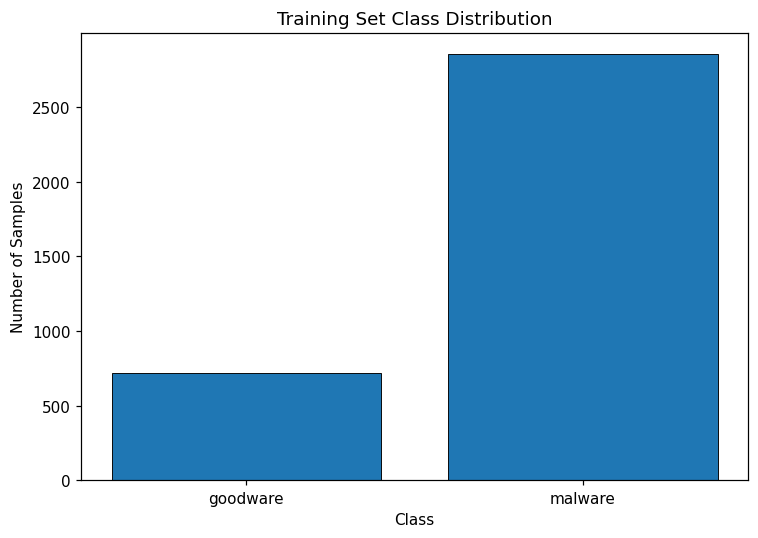

In [4]:
# Encode target labels (goodware/malware -> 0/1)
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Explicit mapping for transparency (helps when interpreting confusion matrix later)
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f'Class Matches: {mapping}')

# Separate features and target
X = df.drop('Label', axis=1)
y = df['Label']

# Hkeep test set untouched until final evaluation
# stratify=y ensures the same class ratio in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f'Training Set: {X_train.shape[0]} samples')
print(f'Test Set: {X_test.shape[0]} samples')

# confirm class distribution in the training set
plot_class_distribution(
    y_train,
    class_names=list(le.classes_),
    title='Training Set Class Distribution'
)

## 4) Transformers for Pipeline

## Custom DataFrame-Compatible Transformers (Pipeline-Safe)

This cell defines custom preprocessing and feature-selection transformers that are **fully compatible with scikit-learn Pipelines** while preserving **pandas DataFrame** structure (column names + index).

**Why custom transformers?**
- Many scikit-learn selectors return NumPy arrays, which can cause feature names to be lost.
- Keeping DataFrames makes downstream steps (feature importance, correlation plots, error analysis) more interpretable.
- All steps are placed **inside the Pipeline** to ensure they are fitted **only on training folds during CV**, preventing data leakage.

**Transformers included**
- `VarianceThresholdDF`: removes near-constant features (low variance).
- `CorrelationFilterDF`: removes highly correlated features to reduce redundancy.
- `SelectKBestMIDF`: selects top-*k* features using Mutual Information with the target.
- `StandardScalerDF`: applies standardization while preserving column names.

**Utility**
- `get_selected_feature_names(...)` retrieves the final feature set used by a fitted pipeline, helping interpretation and reporting.


In [5]:
class VarianceThresholdDF(BaseEstimator, TransformerMixin):
    """
    Removes near-constant features using VarianceThreshold, but returns a DataFrame
    with only the kept columns (preserves column names + index).
    """
    def __init__(self, threshold=0.01):
        self.threshold = threshold
        self.selector_ = VarianceThreshold(threshold=self.threshold)
        self.kept_cols_ = None

    def fit(self, X, y=None):
        # Fit selector on training data only (handled by Pipeline/CV)
        self.selector_.fit(X)
        # Store which columns survive the variance filter
        self.kept_cols_ = list(X.columns[self.selector_.get_support()])
        return self

    def transform(self, X):
        # Return filtered DataFrame (no NumPy conversion → preserves feature names)
        return X[self.kept_cols_].copy()


class CorrelationFilterDF(BaseEstimator, TransformerMixin):
    """
    Drops one feature from each pair/group of highly correlated features.
    Uses absolute Pearson correlation and removes columns with correlation > threshold.
    Returns a DataFrame preserving column names.
    """
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.to_drop_ = None
        self.kept_cols_ = None

    def fit(self, X, y=None):
        # Compute absolute correlation matrix
        corr_matrix = X.corr().abs()

        # Consider only upper triangle to avoid duplicate pairs
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Drop columns that are highly correlated with ANY previous column
        self.to_drop_ = [col for col in upper.columns if any(upper[col] > self.threshold)]
        self.kept_cols_ = [c for c in X.columns if c not in self.to_drop_]
        return self

    def transform(self, X):
        # Keep only non-dropped columns (preserves DataFrame format)
        return X[self.kept_cols_].copy()


class SelectKBestMIDF(BaseEstimator, TransformerMixin):
    """
    Selects the top-k features using Mutual Information (MI) with the target.
    MI is useful for capturing non-linear relationships between features and labels.

    Stores:
    - selected_cols_: final selected feature names
    - scores_: MI scores for all features (for reporting/plots)
    """
    def __init__(self, k=60, random_state=42):
        self.k = k
        self.random_state = random_state
        self.selector_ = None
        self.selected_cols_ = None
        self.scores_ = None

    def fit(self, X, y):
        # Wrap mutual_info_classif with a fixed random_state for reproducibility
        def mi_score_func(X_arr, y_arr):
            return mutual_info_classif(X_arr, y_arr, random_state=self.random_state)

        # Select top-k features by MI score
        self.selector_ = SelectKBest(score_func=mi_score_func, k=self.k)
        self.selector_.fit(X.values, y)

        # Save selected column names
        support = self.selector_.get_support()
        self.selected_cols_ = list(X.columns[support])

        # Save MI scores for ALL columns (sorted) for later visualization/interpretation
        self.scores_ = pd.Series(self.selector_.scores_, index=X.columns).sort_values(ascending=False)
        return self

    def transform(self, X):
        # Return only selected columns as a DataFrame
        return X[self.selected_cols_].copy()


class StandardScalerDF(BaseEstimator, TransformerMixin):
    """
    Standardizes features (zero mean, unit variance) while preserving DataFrame output.

    Note:
    - Scaling is important for distance-based / linear models (e.g., Logistic Regression, SVM, KNN).
    - For tree-based models, scaling is typically not required.
    """
    def __init__(self):
        self.scaler_ = StandardScaler()
        self.cols_ = None

    def fit(self, X, y=None):
        self.cols_ = list(X.columns)
        self.scaler_.fit(X.values)
        return self

    def transform(self, X):
        arr = self.scaler_.transform(X.values)
        return pd.DataFrame(arr, columns=self.cols_, index=X.index)


def get_selected_feature_names(fitted_pipeline: Pipeline):
    """
    Utility to retrieve the final feature names after preprocessing/selection.

    This is useful for:
    - feature importance plots,
    - correlation heatmaps of selected features,
    - error analysis / interpretation sections.

    Returns:
    - list of selected/kept column names, depending on which step exists in the pipeline.
    """
    if 'select' in fitted_pipeline.named_steps:
        return fitted_pipeline.named_steps['select'].selected_cols_
    if 'corr' in fitted_pipeline.named_steps:
        return fitted_pipeline.named_steps['corr'].kept_cols_
    if 'var' in fitted_pipeline.named_steps:
        return fitted_pipeline.named_steps['var'].kept_cols_
    return None


## 5) Evaluation

## Evaluation Utilities (Metrics, Curves, Confusion Matrix, Error Analysis)

This cell defines evaluation helpers used to report model performance in a **consistent and reproducible** way.

**Key outputs**
- **Classification report:** precision / recall / F1 per class + overall metrics
- **Confusion matrix:** visualized and saved for the report
- **ROC-AUC and PR-AUC:** computed only when the task is binary and the model provides a continuous score
- **ROC & PR curves:** plotted and saved under `figures/`
- **Error analysis (6.4):** explicitly lists **False Positives** and **False Negatives**, and displays example misclassified samples to identify potential patterns

**Important note**
- ROC-AUC / PR-AUC require a **continuous score** (probabilities or decision function).  
  The `get_score_vector()` function standardizes this across different model types.

In [6]:
def get_score_vector(model, X):
    """
    Returns a continuous score vector used for ROC-AUC / PR-AUC.

    Priority:
    1) predict_proba -> P(class=1) for binary tasks
    2) decision_function -> raw decision scores
    If neither exists, returns None (AUC metrics cannot be computed).
    """

    # Probability-based score (preferred when available)
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X)
        # For binary classification, use probability of the positive class (class=1)
        if proba.ndim == 2 and proba.shape[1] >= 2:
            return proba[:, 1]
        return proba.ravel()

    # Margin/score-based output (e.g., linear SVM)
    if hasattr(model, 'decision_function'):
        scores = model.decision_function(X)
        return np.asarray(scores).ravel()

    # No continuous score available
    return None


def evaluate_model(model, X_test, y_test, model_name, class_names, plot_curves=True):
    """
    Evaluate a fitted model on the hold-out test set.

    Outputs:
    - classification_report (per-class precision/recall/F1)
    - confusion matrix plot
    - error analysis (FP/FN indices + example rows)
    - ROC-AUC & PR-AUC (if binary + continuous score available)
    - ROC/PR curves (optional)

    Returns a dictionary of summary metrics for model comparison tables.
    """

    # Discrete predictions (used for confusion matrix + F1/accuracy)
    y_pred = model.predict(X_test)

    print(f' {model_name} Scores')
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix for interpretation and report
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
    plot_confusion_matrix(cm, class_names=class_names, title=f'{model_name} - Confusion Matrix')

    # Error Analysis:
    # Assumption: label encoding order corresponds to class_names:
    # 0 -> class_names[0] (e.g., goodware), 1 -> class_names[1] (e.g., malware)
    # FP: true=0 but predicted=1  (benign predicted as malware)
    # FN: true=1 but predicted=0  (malware predicted as benign)
    y_true = np.array(y_test)
    y_pred_arr = np.array(y_pred)

    fp_mask = (y_true == 0) & (y_pred_arr == 1)
    fn_mask = (y_true == 1) & (y_pred_arr == 0)

    fp_idx = np.where(fp_mask)[0]
    fn_idx = np.where(fn_mask)[0]

    print('\nError Analysis (Misclassified Samples)')
    print(f'False Positives (goodware → malware): {len(fp_idx)}')
    print(f'False Negatives (malware → goodware): {len(fn_idx)}')

    # Preserve feature names if X_test is a DataFrame; otherwise create generic names
    if isinstance(X_test, pd.DataFrame):
        X_test_df = X_test.copy()
    else:
        X_test_df = pd.DataFrame(X_test, columns=[f'f{i}' for i in range(X_test.shape[1])])

    # Show a small sample for qualitative pattern inspection (rubric requirement)
    if len(fp_idx) > 0:
        print('\nSample False Positives (first 5 rows):')
        display(X_test_df.iloc[fp_idx].head(5))

    if len(fn_idx) > 0:
        print('\nSample False Negatives (first 5 rows):')
        display(X_test_df.iloc[fn_idx].head(5))

    # Aggregate metrics on test predictions (for comparison table)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_acc = accuracy_score(y_test, y_pred)

    # Continuous score vector for ROC/PR metrics (binary only)
    score_vec = get_score_vector(model, X_test)

    roc_auc = None
    pr_auc = None

    # ROC-AUC / PR-AUC are defined for binary tasks (multi-class requires adaptation)
    is_binary = (len(np.unique(y_test)) == 2)
    if is_binary and score_vec is not None:
        roc_auc = roc_auc_score(y_test, score_vec)
        pr_auc = average_precision_score(y_test, score_vec)

        print(f'ROC-AUC: {roc_auc:.4f}')
        print(f'PR-AUC (Average Precision): {pr_auc:.4f}')

        # Optional: performance curves saved for report
        if plot_curves:
            fpr, tpr, _ = roc_curve(y_test, score_vec)
            plt.figure(figsize=(6, 5))
            plt.plot(fpr, tpr)
            plt.plot([0, 1], [0, 1], linestyle='--')
            plt.title(f'{model_name} - ROC Curve (AUC={roc_auc:.3f})')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.tight_layout()
            save_current_fig("roc.png")
            plt.show()

            precision, recall, _ = precision_recall_curve(y_test, score_vec)
            plt.figure(figsize=(6, 5))
            plt.plot(recall, precision)
            plt.title(f'{model_name} - Precision-Recall Curve (AP={pr_auc:.3f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.tight_layout()
            save_current_fig("pr_curve.png")
            plt.show()
    else:
        # Informative messages when AUC curves cannot be computed
        if not is_binary:
            print('ROC-AUC / PR-AUC: Multi-class için ek uyarlama gerekir')
        elif score_vec is None:
            print('ROC-AUC / PR-AUC: Model continuous skor üretmedi')

    # Returned dict is used to build a model comparison table
    return {
        'f1_weighted': test_f1,
        'accuracy': test_acc,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
    }


## Baseline + Model Training, Hyperparameter Optimization, and Comparison

This section performs the core modeling workflow required by the project rubric:

**1) Baseline**
- Train and evaluate a `DummyClassifier` baseline to establish a minimum performance reference.

**2) Candidate Models**
- Define multiple real ML models with a consistent preprocessing + feature-selection pipeline:
  - Logistic Regression (scaled)
  - Random Forest
  - HistGradientBoosting

**3) Hyperparameter Search (Training-only)**
- Use `GridSearchCV` with **StratifiedKFold (k=5)** on the **training set only** to select the best hyperparameters based on **weighted F1**.
- Preprocessing and feature selection are performed **inside the pipeline**, ensuring they are refit within CV folds (prevents data leakage).

**4) Final Evaluation (Hold-out Test)**
- After selecting the best estimator for each model, evaluate it once on the hold-out test set.
- Collect all results into a comparison table for reporting.

> Note: The hold-out test set is used only for final reporting; model selection is driven by cross-validation on the training set.


## 6) Baseline + Model Pipelines + GridSearchCV

1) Baseline (Dummy) Model is being evaluated.
 Baseline (Dummy) Model Scores
              precision    recall  f1-score   support

    goodware       0.00      0.00      0.00       180
     malware       0.80      1.00      0.89       713

    accuracy                           0.80       893
   macro avg       0.40      0.50      0.44       893
weighted avg       0.64      0.80      0.71       893



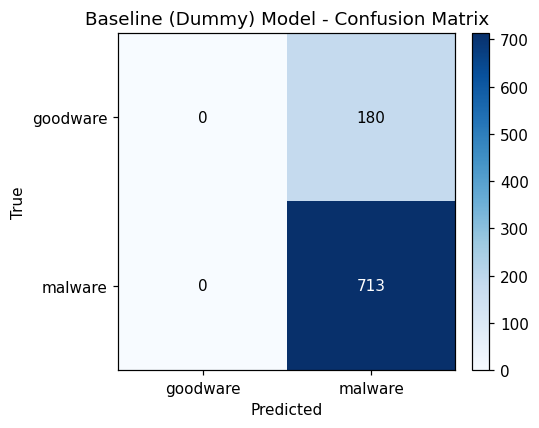


Error Analysis (Misclassified Samples)
False Positives (goodware → malware): 180
False Negatives (malware → goodware): 0

Sample False Positives (first 5 rows):


,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/content/pm/PackageManager;->getInstalledPackages,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute
4268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4037,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


ROC-AUC: 0.5000
PR-AUC (Average Precision): 0.7984
2) The Training and Optimization Process Has Begun.
Logistic Regression Being Optimized
[Logistic Regression] Selected feature count: 57
Random Forest Being Optimized
[Random Forest] Selected feature count: 60
HistGradientBoosting Being Optimized
[HistGradientBoosting] Selected feature count: 57
 Logistic Regression (Test – Reporting Only) Scores
              precision    recall  f1-score   support

    goodware       0.99      0.94      0.97       180
     malware       0.99      1.00      0.99       713

    accuracy                           0.99       893
   macro avg       0.99      0.97      0.98       893
weighted avg       0.99      0.99      0.99       893



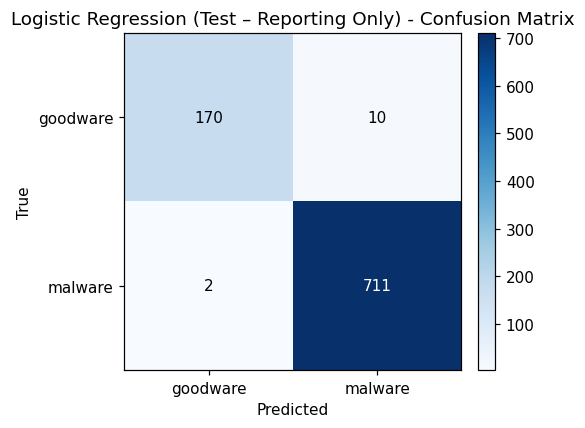


Error Analysis (Misclassified Samples)
False Positives (goodware → malware): 10
False Negatives (malware → goodware): 2

Sample False Positives (first 5 rows):


,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/content/pm/PackageManager;->getInstalledPackages,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute
4457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3075,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0



Sample False Negatives (first 5 rows):


,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/content/pm/PackageManager;->getInstalledPackages,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute
1301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


ROC-AUC: 0.9919
PR-AUC (Average Precision): 0.9966
 Random Forest (Test – Reporting Only) Scores
              precision    recall  f1-score   support

    goodware       1.00      0.99      0.99       180
     malware       1.00      1.00      1.00       713

    accuracy                           1.00       893
   macro avg       1.00      0.99      1.00       893
weighted avg       1.00      1.00      1.00       893



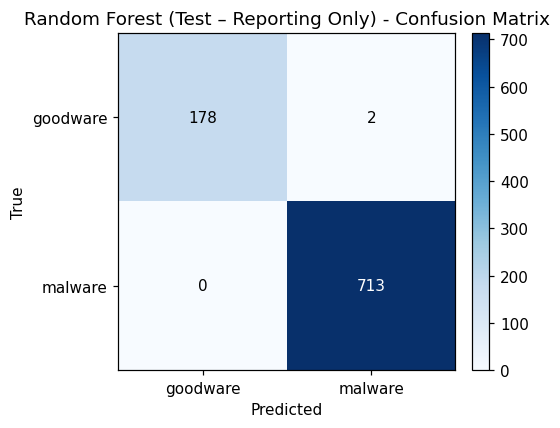


Error Analysis (Misclassified Samples)
False Positives (goodware → malware): 2
False Negatives (malware → goodware): 0

Sample False Positives (first 5 rows):


,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/content/pm/PackageManager;->getInstalledPackages,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute
4050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ROC-AUC: 1.0000
PR-AUC (Average Precision): 1.0000
 HistGradientBoosting (Test – Reporting Only) Scores
              precision    recall  f1-score   support

    goodware       1.00      0.99      0.99       180
     malware       1.00      1.00      1.00       713

    accuracy                           1.00       893
   macro avg       1.00      0.99      1.00       893
weighted avg       1.00      1.00      1.00       893



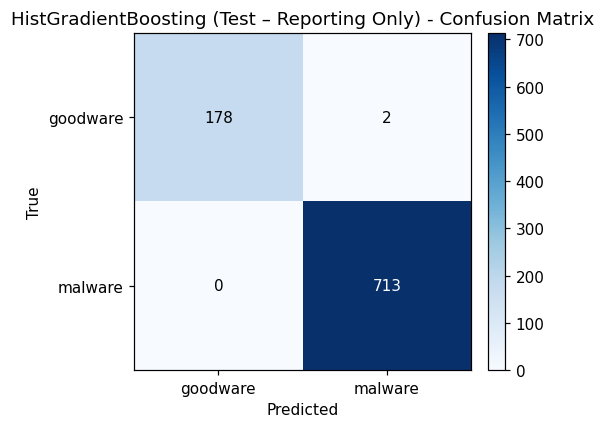


Error Analysis (Misclassified Samples)
False Positives (goodware → malware): 2
False Negatives (malware → goodware): 0

Sample False Positives (first 5 rows):


,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/content/pm/PackageManager;->getInstalledPackages,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute
4050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ROC-AUC: 1.0000
PR-AUC (Average Precision): 1.0000


,Model,Best CV F1,Test F1,Test Accuracy,Test ROC-AUC,Test PR-AUC,Best Params
2,Random Forest,0.991897,0.997756,0.997760,0.999984,0.999996,"{'corr__threshold': 0.9, 'model__class_weight'..."
3,HistGradientBoosting,0.991597,0.997756,0.997760,0.999969,0.999992,"{'corr__threshold': 0.85, 'model__learning_rat..."
1,Logistic Regression,0.985671,0.986447,0.986562,0.991912,0.996555,"{'corr__threshold': 0.85, 'model__C': 10, 'mod..."
0,Baseline (Dummy),NaN,0.708944,0.798432,0.500000,0.798432,N/A


CV (No Test) Confusion Matrix + F1 + ROC/PR for Each Model

[Logistic Regression] CV OOF F1 (weighted): 0.9857


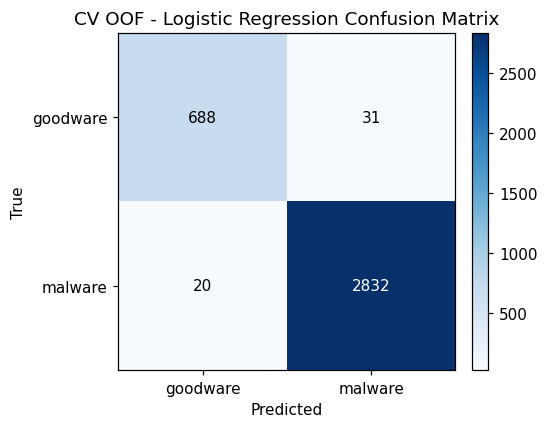

    CV OOF ROC-AUC: 0.9912
    CV OOF PR-AUC : 0.9943


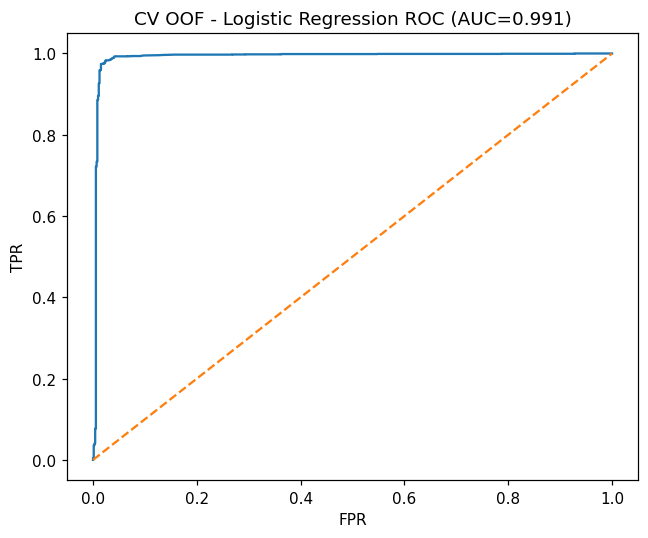

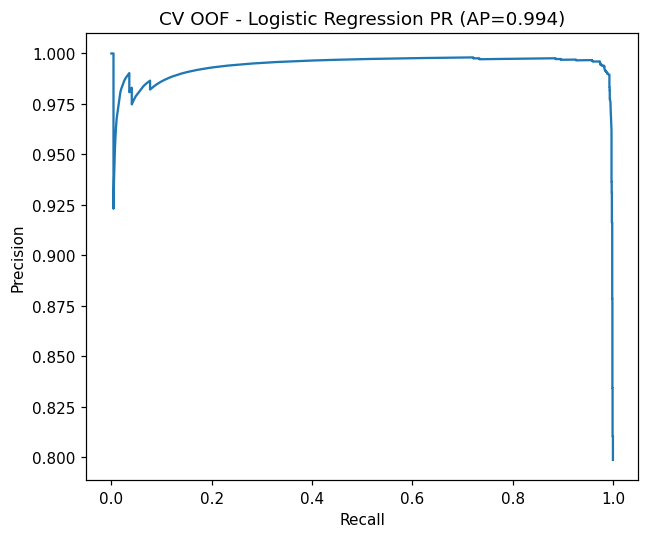


[Random Forest] CV OOF F1 (weighted): 0.9919


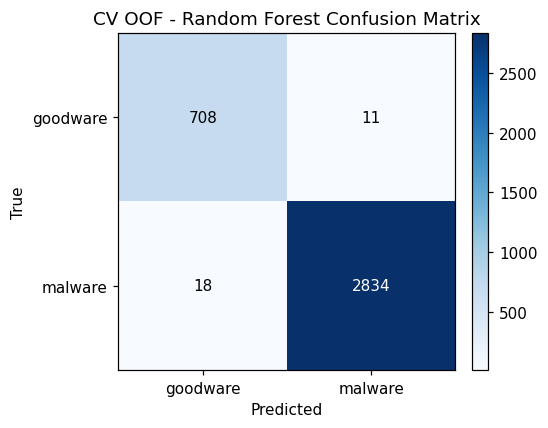

    CV OOF ROC-AUC: 0.9985
    CV OOF PR-AUC : 0.9996


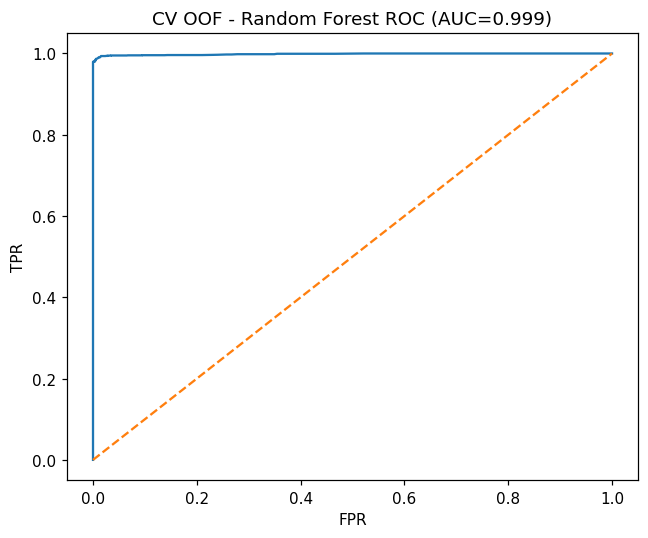

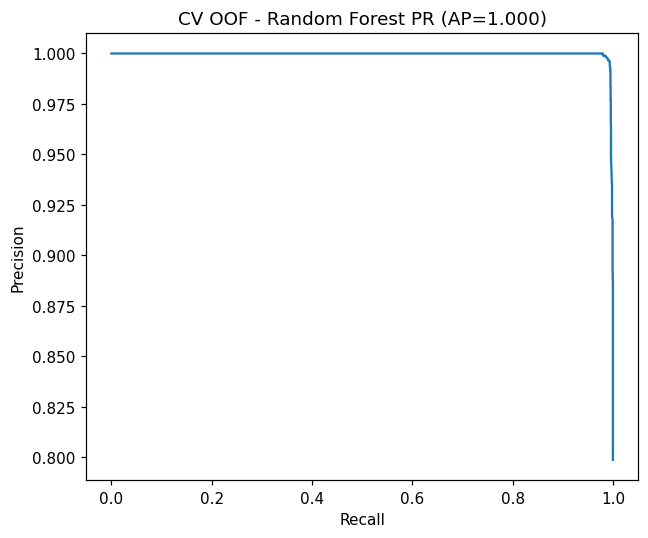


[HistGradientBoosting] CV OOF F1 (weighted): 0.9916


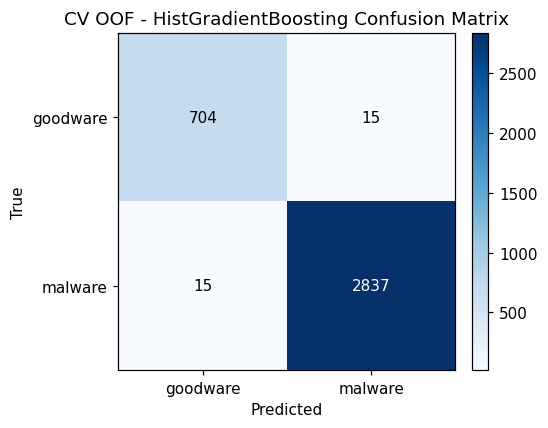

    CV OOF ROC-AUC: 0.9988
    CV OOF PR-AUC : 0.9997


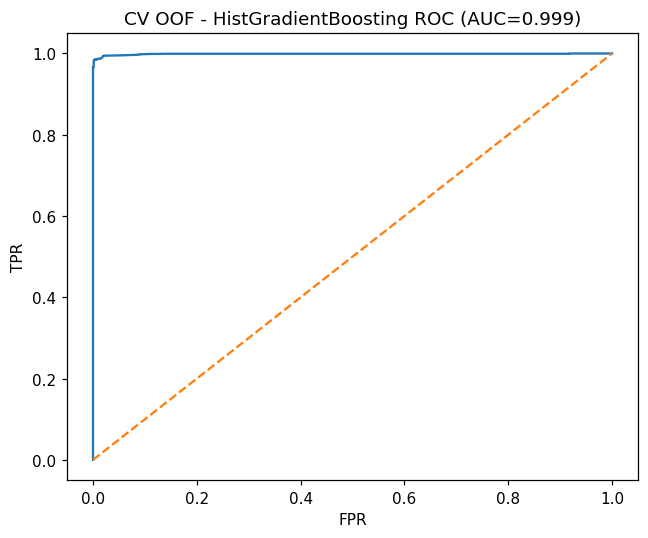

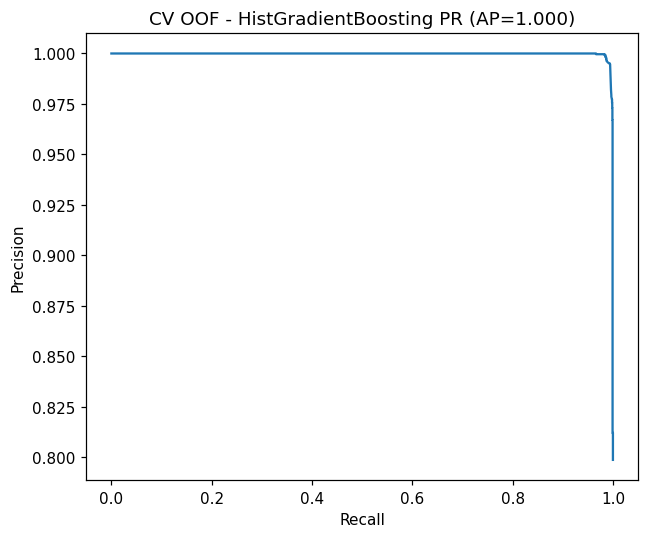

Selected best model by CV: Random Forest
 FINAL (Selected by CV): Random Forest Scores
              precision    recall  f1-score   support

    goodware       1.00      0.99      0.99       180
     malware       1.00      1.00      1.00       713

    accuracy                           1.00       893
   macro avg       1.00      0.99      1.00       893
weighted avg       1.00      1.00      1.00       893



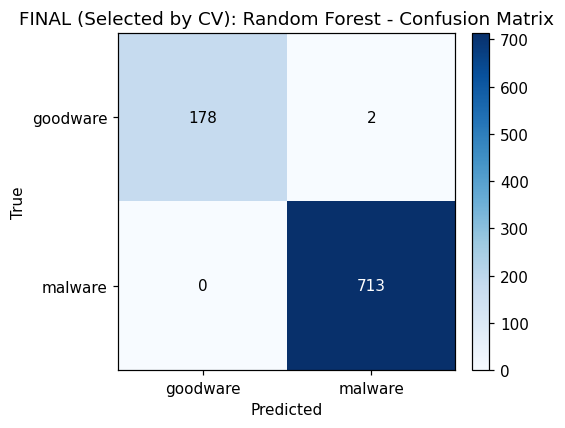


Error Analysis (Misclassified Samples)
False Positives (goodware → malware): 2
False Negatives (malware → goodware): 0

Sample False Positives (first 5 rows):


,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/content/pm/PackageManager;->getInstalledPackages,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute
4050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ROC-AUC: 1.0000
PR-AUC (Average Precision): 1.0000


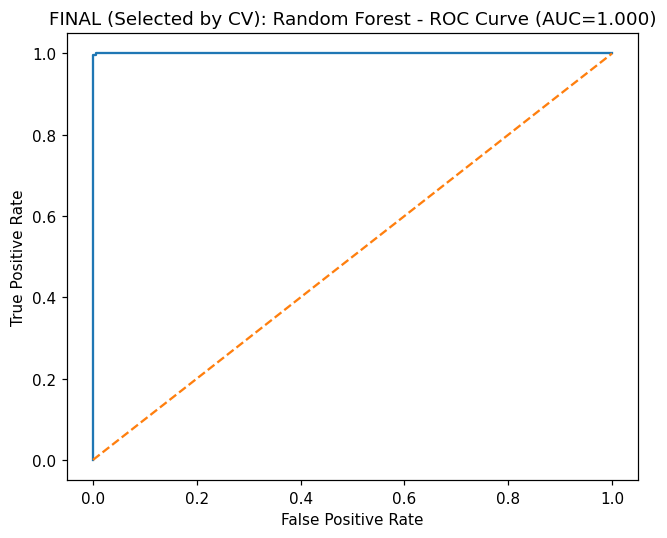

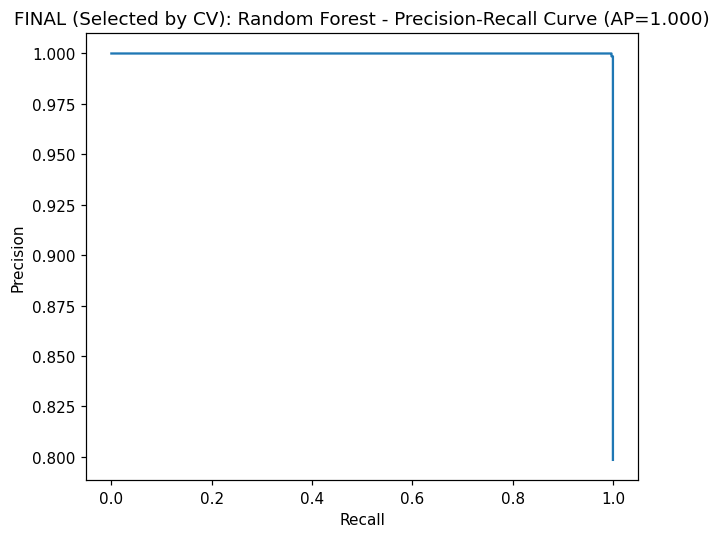

,Model,Best CV F1,Test F1,Test Accuracy,Test ROC-AUC,Test PR-AUC,Best Params
2,Random Forest,0.991897,0.997756,0.997760,0.999984,0.999996,"{'corr__threshold': 0.9, 'model__class_weight'..."
3,HistGradientBoosting,0.991597,0.997756,0.997760,0.999969,0.999992,"{'corr__threshold': 0.85, 'model__learning_rat..."
1,Logistic Regression,0.985671,0.986447,0.986562,0.991912,0.996555,"{'corr__threshold': 0.85, 'model__C': 10, 'mod..."
0,Baseline (Dummy),NaN,0.708944,0.798432,0.500000,0.798432,N/A


In [7]:
# StratifiedKFold keeps class ratios balanced across folds (important for weighted F1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print('1) Baseline (Dummy) Model is being evaluated.')

# Baseline strategy: always predict the most frequent class
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)

# Baseline test evaluation (reference only)
metrics_dummy = evaluate_model(
    dummy_clf, X_test, y_test,
    model_name='Baseline (Dummy) Model',
    class_names=list(le.classes_),
    plot_curves=False
)

comparison_table = [{
    'Model': 'Baseline (Dummy)',
    'Best CV F1': np.nan,
    'Test F1': metrics_dummy['f1_weighted'],
    'Test Accuracy': metrics_dummy['accuracy'],
    'Test ROC-AUC': metrics_dummy['roc_auc'],
    'Test PR-AUC': metrics_dummy['pr_auc'],
    'Best Params': 'N/A'
}]

best_models = {}

preprocess_common = [
    ('var', VarianceThresholdDF(threshold=0.01)),
    ('corr', CorrelationFilterDF(threshold=0.9)),
    ('select', SelectKBestMIDF(k=60, random_state=42)),
]

lr_pipeline = Pipeline(steps=[
    *preprocess_common,
    ('scaler', StandardScalerDF()),
    ('model', LogisticRegression(max_iter=2000, random_state=42))
])

rf_pipeline = Pipeline(steps=[
    *preprocess_common,
    ('model', RandomForestClassifier(random_state=42))
])

hgb_pipeline = Pipeline(steps=[
    *preprocess_common,
    ('model', HistGradientBoostingClassifier(random_state=42))
])

model_pipeline = {
    'Logistic Regression': {
        'pipeline': lr_pipeline,
        'params': {
            'select__k': [20, 60, 100],
            'corr__threshold': [0.85, 0.9, 0.95],
            'model__C': [0.1, 1, 10],
            'model__penalty': ['l2'],
            'model__class_weight': [None, 'balanced'],
        }
    },
    'Random Forest': {
        'pipeline': rf_pipeline,
        'params': {
            'select__k': [20, 60, 100],
            'corr__threshold': [0.85, 0.9, 0.95],
            'model__n_estimators': [200, 500],
            'model__max_depth': [None, 10, 20],
            'model__class_weight': [None, 'balanced'],
        }
    },
    'HistGradientBoosting': {
        'pipeline': hgb_pipeline,
        'params': {
            'select__k': [20, 60, 100],
            'corr__threshold': [0.85, 0.9, 0.95],
            'model__learning_rate': [0.03, 0.1],
            'model__max_depth': [3, 6, None],
            'model__max_iter': [200, 500],
            'model__min_samples_leaf': [10, 30],
        }
    }
}

print('2) The Training and Optimization Process Has Begun.')

# GridSearchCV per model (TRAIN ONLY) -> store CV best score
for name, config in model_pipeline.items():
    print(f"{name} Being Optimized")

    gs = GridSearchCV(
        estimator=config['pipeline'],
        param_grid=config['params'],
        cv=cv,
        scoring='f1_weighted',
        n_jobs=-1
    )

    gs.fit(X_train, y_train)

    best_model = gs.best_estimator_
    best_models[name] = best_model

    # Store CV score for selection (no test usage here)
    comparison_table.append({
        'Model': name,
        'Best CV F1': gs.best_score_,
        'Test F1': np.nan,          # will be filled ONLY for selected model
        'Test Accuracy': np.nan,
        'Test ROC-AUC': np.nan,
        'Test PR-AUC': np.nan,
        'Best Params': gs.best_params_
    })

    selected_cols = get_selected_feature_names(best_model)
    if selected_cols is not None:
        print(f'[{name}] Selected feature count: {len(selected_cols)}')

for row in comparison_table:
    model_name = row["Model"]

    # Skip baseline (already evaluated)
    if model_name == "Baseline (Dummy)":
        continue

    # Eğer test metrikleri NaN ise, test evaluation yap
    if pd.isna(row["Test F1"]):
        pipe = best_models.get(model_name)
        if pipe is None:
            continue

        metrics = evaluate_model(
            pipe,
            X_test,
            y_test,
            model_name=f"{model_name} (Test – Reporting Only)",
            class_names=list(le.classes_),
            plot_curves=False
        )

        row["Test F1"] = metrics["f1_weighted"]
        row["Test Accuracy"] = metrics["accuracy"]
        row["Test ROC-AUC"] = metrics["roc_auc"]
        row["Test PR-AUC"] = metrics["pr_auc"]

# Create results table and select best model by CV
results_df = pd.DataFrame(comparison_table)

results_df["Best CV F1"] = pd.to_numeric(results_df["Best CV F1"], errors="coerce")
results_df = results_df.sort_values(by="Best CV F1", ascending=False)

display(results_df)


print("CV (No Test) Confusion Matrix + F1 + ROC/PR for Each Model")

for name, pipe in best_models.items():  # best_models: GridSearch sonrası best_estimator_ sakladığın dict
    # 1) OOF class prediction -> CM + F1
    y_oof_pred = cross_val_predict(pipe, X_train, y_train, cv=cv, method="predict")
    cm = confusion_matrix(y_train, y_oof_pred, labels=np.arange(len(le.classes_)))
    f1 = f1_score(y_train, y_oof_pred, average="weighted")

    print(f"\n[{name}] CV OOF F1 (weighted): {f1:.4f}")
    plot_confusion_matrix(cm, class_names=list(le.classes_), title=f"CV OOF - {name} Confusion Matrix")

    # 2) OOF score -> ROC/PR (if possible)
    score_vec = None
    try:
        y_oof_proba = cross_val_predict(pipe, X_train, y_train, cv=cv, method="predict_proba")
        if y_oof_proba.ndim == 2 and y_oof_proba.shape[1] >= 2:
            score_vec = y_oof_proba[:, 1]
        else:
            score_vec = y_oof_proba.ravel()
    except Exception:
        try:
            score_vec = cross_val_predict(pipe, X_train, y_train, cv=cv, method="decision_function")
            score_vec = np.asarray(score_vec).ravel()
        except Exception:
            score_vec = None

    if score_vec is not None and len(np.unique(y_train)) == 2:
        roc_auc = roc_auc_score(y_train, score_vec)
        pr_auc = average_precision_score(y_train, score_vec)

        print(f"    CV OOF ROC-AUC: {roc_auc:.4f}")
        print(f"    CV OOF PR-AUC : {pr_auc:.4f}")

        fpr, tpr, _ = roc_curve(y_train, score_vec)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1], linestyle="--")
        plt.title(f"CV OOF - {name} ROC (AUC={roc_auc:.3f})")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.tight_layout()
        plt.show()

        prec, rec, _ = precision_recall_curve(y_train, score_vec)
        plt.figure(figsize=(6,5))
        plt.plot(rec, prec)
        plt.title(f"CV OOF - {name} PR (AP={pr_auc:.3f})")
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.tight_layout()
        plt.show()
    else:
        print("    ROC/PR skipped: model does not expose a usable score vector.")


# Select best model (exclude baseline)
candidate_df = results_df[results_df['Model'] != 'Baseline (Dummy)'].dropna(subset=['Best CV F1'])
best_name = candidate_df.iloc[0]['Model']
print("Selected best model by CV:", best_name)

# FINAL (hold-out) test evaluation: ONLY for the selected model
best_pipe = best_models[best_name]
final_metrics = evaluate_model(
    best_pipe, X_test, y_test,
    model_name=f'FINAL (Selected by CV): {best_name}',
    class_names=list(le.classes_),
    plot_curves=True
)

# Write final test results back into the table for reporting
results_df.loc[results_df['Model'] == best_name, 'Test F1'] = final_metrics['f1_weighted']
results_df.loc[results_df['Model'] == best_name, 'Test Accuracy'] = final_metrics['accuracy']
results_df.loc[results_df['Model'] == best_name, 'Test ROC-AUC'] = final_metrics['roc_auc']
results_df.loc[results_df['Model'] == best_name, 'Test PR-AUC'] = final_metrics['pr_auc']

display(results_df)

## 7) Results Summary + F1 Comparison Chart

## Results Summary & Visualization (Model Comparison)

This cell summarizes the final results obtained on the **hold-out test set** and visualizes model performance.

**What is included**
- A compact table showing key metrics for each model:
  - Weighted F1 (primary comparison metric)
  - Accuracy
  - ROC-AUC and PR-AUC (binary task only)
  - Best cross-validation F1 (used during model selection)
- A bar chart comparing **Test F1** scores across all evaluated models.

**Why this matters**
- Provides a clear and reproducible comparison between baseline and real models.
- The plot is saved under `figures/` for direct inclusion in the project report.

                  Model   Test F1  Test Accuracy  Test ROC-AUC  Test PR-AUC  \
2         Random Forest  0.997756       0.997760      0.999984     0.999996   
3  HistGradientBoosting  0.997756       0.997760      0.999969     0.999992   
1   Logistic Regression  0.986447       0.986562      0.991912     0.996555   
0      Baseline (Dummy)  0.708944       0.798432      0.500000     0.798432   

   Best CV F1  
2    0.991897  
3    0.991597  
1    0.985671  
0         NaN  


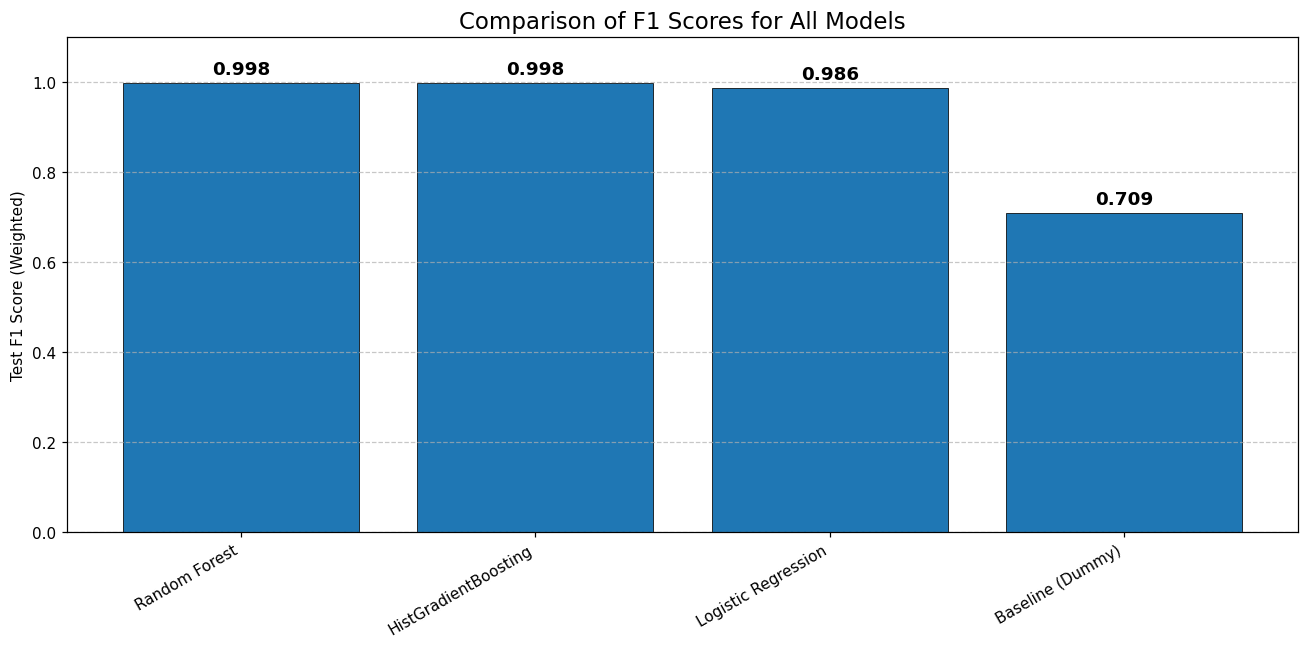

In [8]:
# Results table + visualization

# Print key metrics in a compact format
print(results_df[['Model', 'Test F1', 'Test Accuracy', 'Test ROC-AUC', 'Test PR-AUC', 'Best CV F1']])

# Prepare data for plotting
plt.figure(figsize=(12, 6))
models = results_df['Model'].astype(str).values
scores = results_df['Test F1'].values

# Bar plot of weighted F1 scores (test set)
plt.bar(models, scores, edgecolor='black', linewidth=0.5)
plt.title('Comparison of F1 Scores for All Models', fontsize=15)
plt.ylabel('Test F1 Score (Weighted)')

# Keep a bit of headroom above 1.0 for label placement
plt.ylim(0, 1.1)
plt.xticks(rotation=30, ha='right')

# Annotate bars with exact values for easier reading
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold', fontsize=12)

# Light grid improves readability for close scores
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
save_current_fig("model_comparison_f1_score.png")
plt.show()


## 8) ROC/PR Curves for the Best Model

## Final Model Evaluation (Best Model on Hold-out Test)

In this step, we select the best-performing model from the comparison table and run a **final, detailed evaluation** on the hold-out test set.

**What is produced**
- Classification report
- Confusion matrix
- Error analysis (FP/FN examples)
- ROC curve and Precision–Recall curve (if the task is binary and a continuous score is available)

**Note**
- The model choice here is based on the previously computed results table, and the test set is used for **final reporting** of the selected model.


 BEST: Random Forest Scores
              precision    recall  f1-score   support

    goodware       1.00      0.99      0.99       180
     malware       1.00      1.00      1.00       713

    accuracy                           1.00       893
   macro avg       1.00      0.99      1.00       893
weighted avg       1.00      1.00      1.00       893



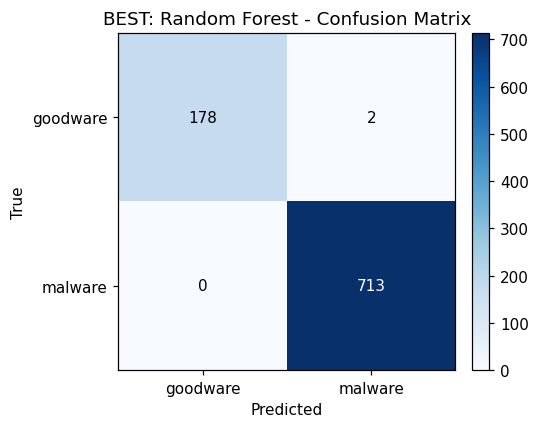


Error Analysis (Misclassified Samples)
False Positives (goodware → malware): 2
False Negatives (malware → goodware): 0

Sample False Positives (first 5 rows):


,ACCESS_ALL_DOWNLOADS,ACCESS_CACHE_FILESYSTEM,ACCESS_CHECKIN_PROPERTIES,ACCESS_COARSE_LOCATION,ACCESS_COARSE_UPDATES,ACCESS_FINE_LOCATION,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_MOCK_LOCATION,ACCESS_MTK_MMHW,ACCESS_NETWORK_STATE,...,Landroid/content/pm/PackageManager;->getInstalledPackages,Landroid/telephony/TelephonyManager;->getLine1Number,Landroid/telephony/TelephonyManager;->getNetworkOperator,Landroid/telephony/TelephonyManager;->getNetworkOperatorName,Landroid/telephony/TelephonyManager;->getNetworkCountryIso,Landroid/telephony/TelephonyManager;->getSimOperator,Landroid/telephony/TelephonyManager;->getSimOperatorName,Landroid/telephony/TelephonyManager;->getSimCountryIso,Landroid/telephony/TelephonyManager;->getSimSerialNumber,Lorg/apache/http/impl/client/DefaultHttpClient;->execute
4050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ROC-AUC: 1.0000
PR-AUC (Average Precision): 1.0000


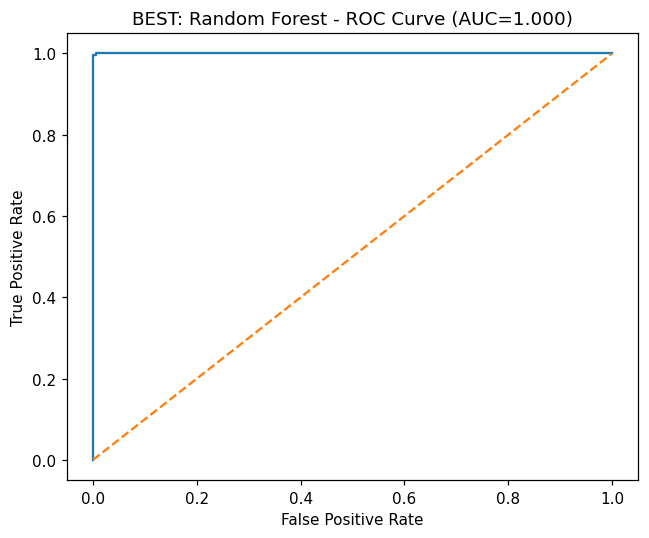

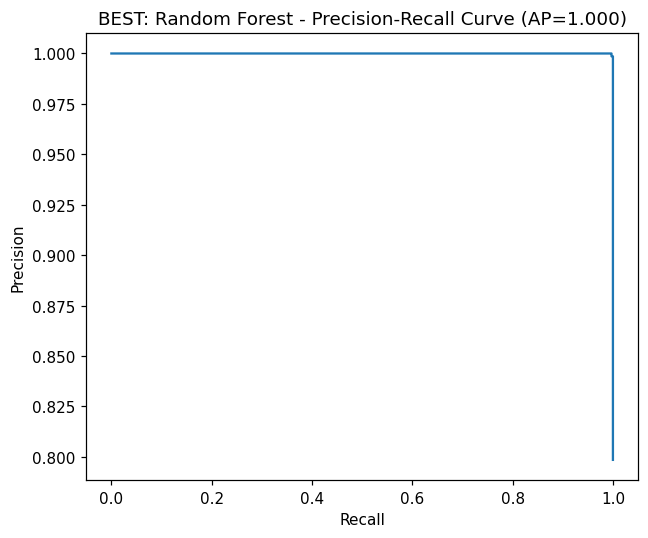

In [9]:
# Retrieve fitted pipeline and evaluate it in detail
if best_name in best_models:
    best_pipe = best_models[best_name]

    # Detailed evaluation includes ROC/PR curves (plot_curves=True)
    _ = evaluate_model(
        best_pipe, X_test, y_test,
        model_name=f'BEST: {best_name}',
        class_names=list(le.classes_),
        plot_curves=True
    )


## 9) Feature Visualizations and MI Scores

## Interpretation & Visualization (MI Scores, Feature Distributions, Correlation)

This section provides model interpretability and supports the **analysis/interpretation** part of the rubric.

**What is done**
- Extract Mutual Information (MI) scores from the fitted pipeline (`SelectKBestMIDF`) to identify the most informative features.
- Visualize the **top-20** MI features with a horizontal bar chart.
- For the **top-2** features, compare feature distributions across classes using grouped counts (useful for spotting class-separating patterns).
- Plot a correlation heatmap among the top-20 features to inspect redundancy and feature interactions.

**Notes**
- MI scores are computed during training (within the pipeline), and this cell uses them for **post-hoc interpretation**.
- Feature name cleaning is applied only for visualization readability (no effect on modeling).


[VIZ] Best model: Random Forest
[VIZ] Top-2 feature: ['RECEIVE_BOOT_COMPLETED', 'Ljava/net/URL;->openConnection']


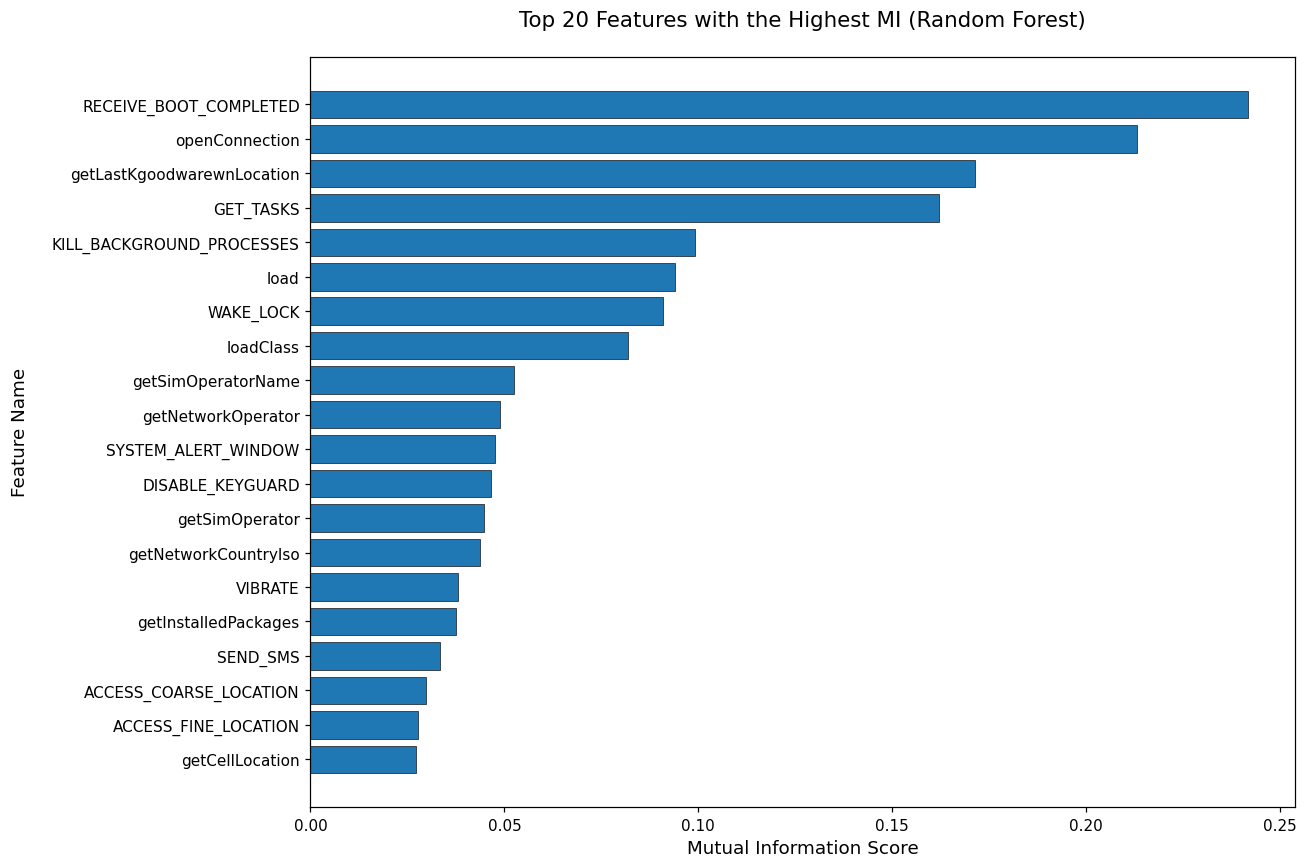

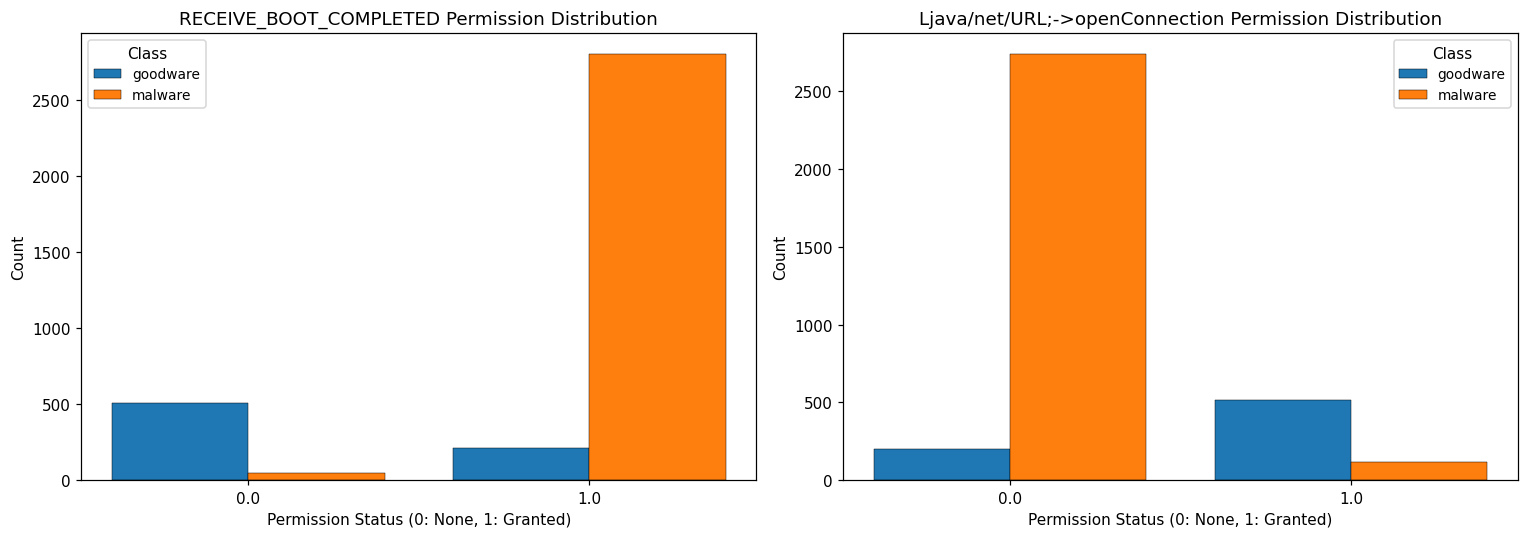

Correlation Heatmap


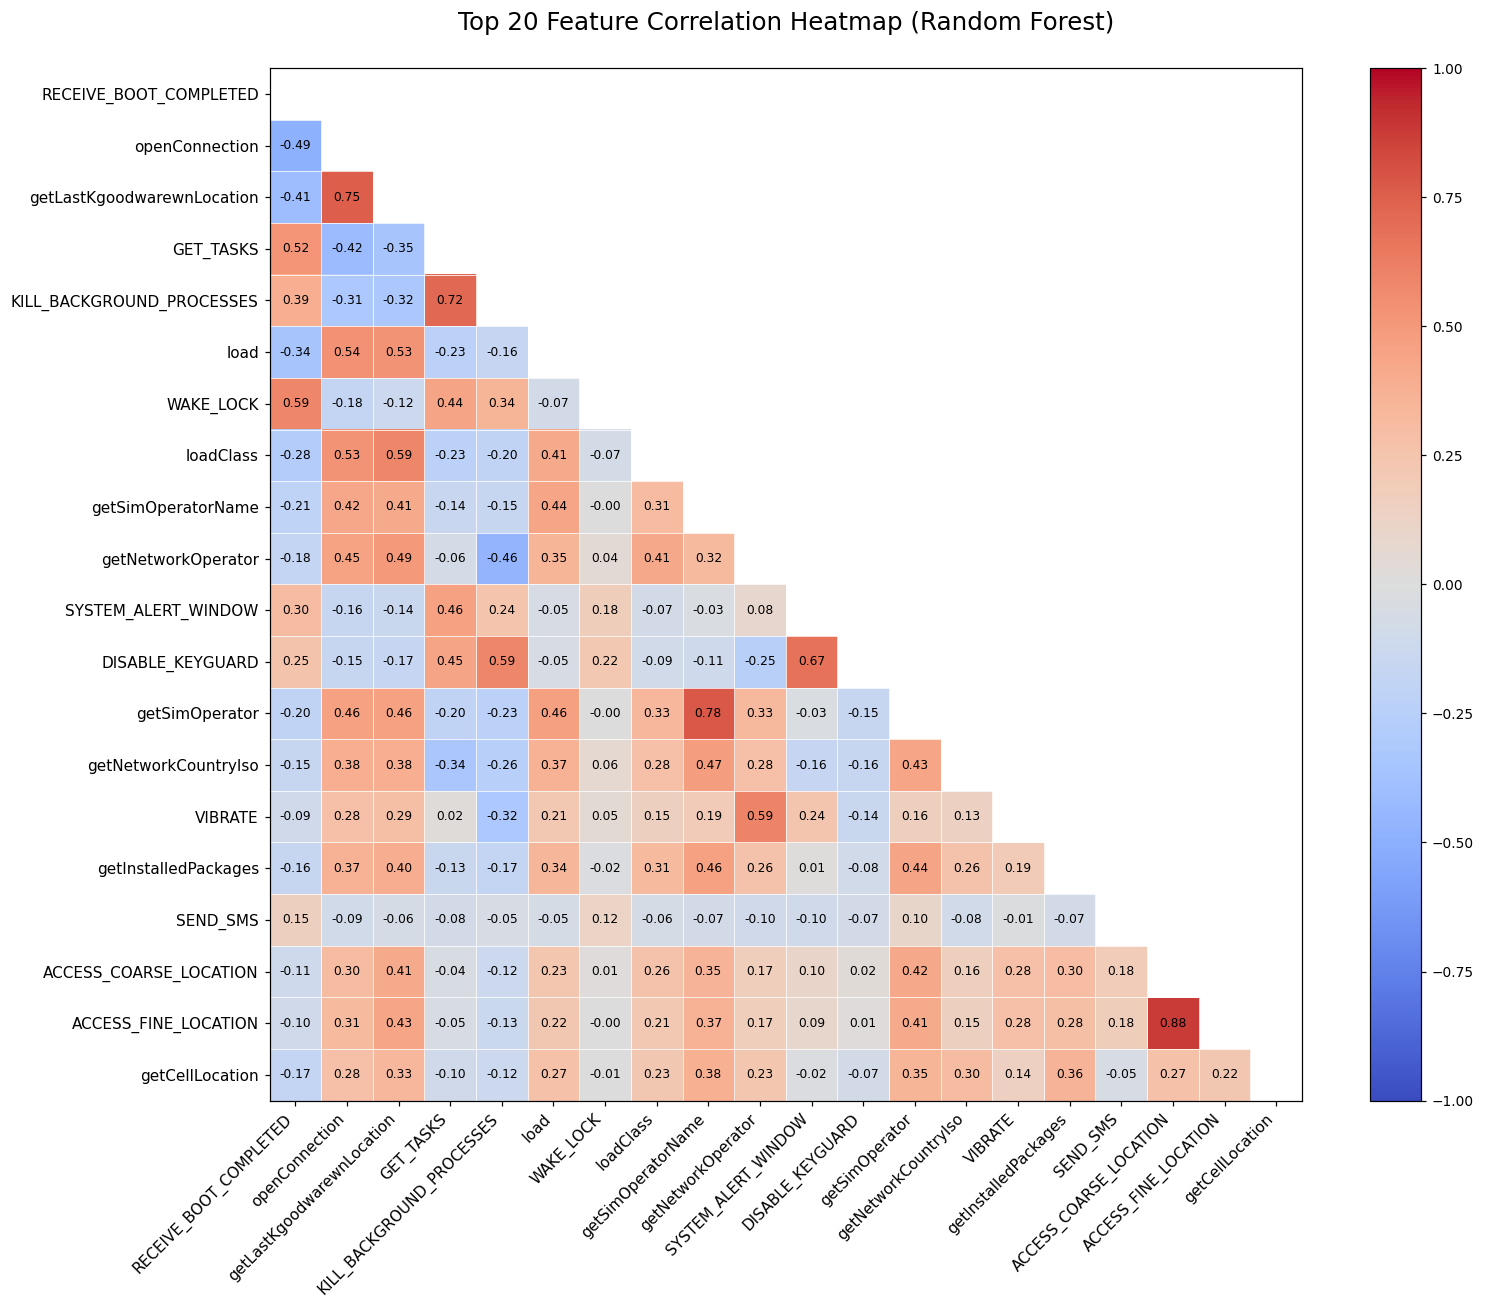

In [10]:
if best_name in best_models:
    # Retrieve the fitted pipeline for the selected best model
    pipe_viz = best_models[best_name]

    # MI scores were stored by SelectKBestMIDF during fit()
    # Sort descending to get the most informative features first
    mi_scores = pipe_viz.named_steps['select'].scores_.sort_values(ascending=False)
    top_20_features = mi_scores.head(20).index.tolist()
    top_2_features = mi_scores.head(2).index.tolist()

    print(f'[VIZ] Best model: {best_name}')
    print(f'[VIZ] Top-2 feature: {top_2_features}')

    # Apply the same preprocessing steps (variance + correlation filtering)
    # so that visualizations match the feature space used by the model
    X_train_var = pipe_viz.named_steps['var'].transform(X_train)
    X_train_proc = pipe_viz.named_steps['corr'].transform(X_train_var)

    # Clean feature names for plot readability (dataset-specific naming cleanup)
    # This is only cosmetic and does not affect training/evaluation.
    clean_names = [name.split('.')[-1].split('->')[-1] for name in mi_scores.head(20).index]

    # Top-20 MI bar chart
    plot_horizontal_bar(
        values=mi_scores.head(20).values,
        names=clean_names,
        title=f'Top 20 Features with the Highest MI ({best_name})',
        xlabel='Mutual Information Score',
        ylabel='Feature Name',
        sort=True
    )

    # Class-wise distribution for the top-2 MI features (0/1 indicators)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    class_names_for_legend = list(le.classes_)

    for i, col in enumerate(top_2_features):
        plot_grouped_count_by_hue(
            x=X_train_proc[col].values,
            y=y_train.values,
            ax=axes[i],
            title=f'{col} Permission Distribution',
            xlabel='Permission Status (0: None, 1: Granted)',
            hue_title='Class',
            class_names=class_names_for_legend
        )

    plt.tight_layout()
    save_current_fig("feature_distribution.png")
    plt.show()

    # Correlation heatmap among top-20 MI features
    print('Correlation Heatmap')

    # Shorten names for heatmap axis readability
    short_names = [name.split('.')[-1].split('->')[-1] for name in top_20_features]

    # Compute correlations on the processed training data (after var + corr filtering)
    corr = X_train_proc[top_20_features].corr()
    corr.index = short_names
    corr.columns = short_names

    plot_correlation_heatmap(
        corr,
        mask_upper=True,
        title=f'Top 20 Feature Correlation Heatmap ({best_name})'
    )


## 10) Feature Importance 

## Feature Importance Analysis (Pipeline-Aware)

This section analyzes **feature importance** for the selected best model in a **pipeline-safe** manner.

**How importance is computed**
- If the final estimator provides native feature importance scores (e.g., tree-based models),
  these are used directly.
- Otherwise, **permutation importance** is computed on the hold-out test set using
  weighted F1 as the scoring metric.

**Why this approach**
- Works consistently across different model families.
- Respects the preprocessing and feature-selection steps inside the pipeline.
- Supports interpretability and complements MI-based feature selection analysis.

The top-15 most important features are visualized and saved for inclusion in the report.


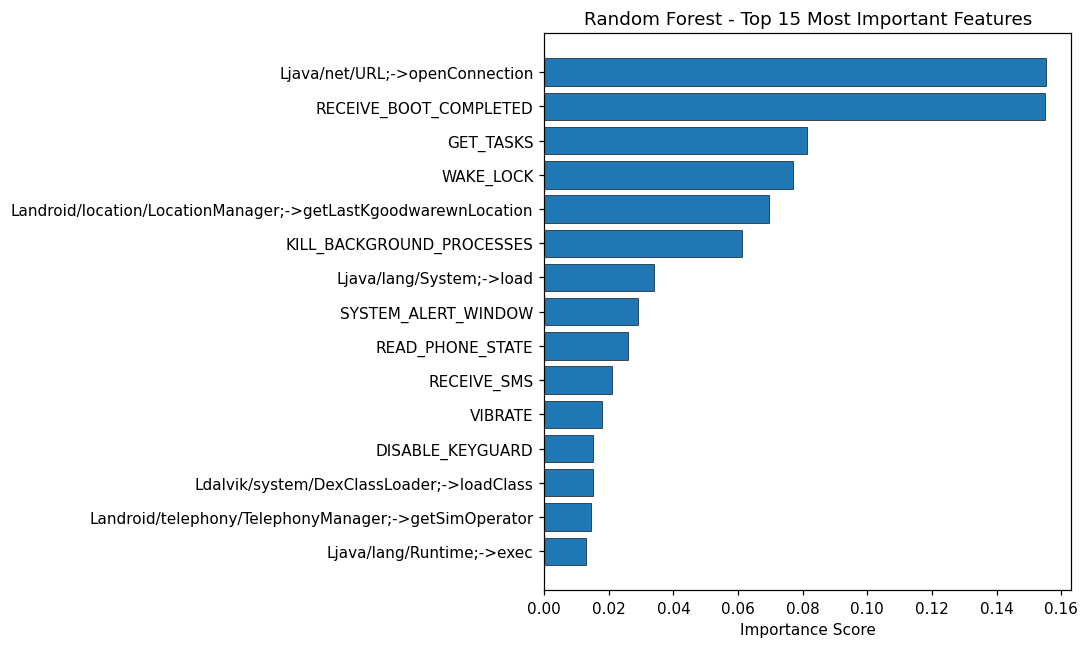

In [11]:
def plot_feature_importance_pipeline(pipeline_model, model_name, X_test, y_test):
    """
    Plot feature importance for a fitted pipeline.

    Parameters:
    - pipeline_model: fitted sklearn Pipeline (with preprocessing + model)
    - model_name: name of the model (used for titles and filenames)
    - X_test, y_test: hold-out test set (used for permutation importance if needed)

    Notes:
    - Feature names are retrieved from the pipeline using get_selected_feature_names().
    - For models without native importance, permutation importance is computed
      using weighted F1 as the scoring metric.
    """

    # Retrieve final selected feature names after preprocessing/selection
    feature_names = get_selected_feature_names(pipeline_model)
    final_est = pipeline_model.named_steps['model']

    if feature_names is None:
        print(f'{model_name}: Feature names could not be retrieved.')
        return

    plt.figure(figsize=(10, 6))

    # Model provides native feature importance (e.g., RandomForest)
    if hasattr(final_est, 'feature_importances_'):
        feat_importances = pd.Series(
            final_est.feature_importances_,
            index=feature_names
        )

    # Model has no native importance → use permutation importance
    else:
        perm = permutation_importance(
            pipeline_model,
            X_test,
            y_test,
            n_repeats=10,
            random_state=42,
            scoring='f1_weighted',
            n_jobs=-1
        )
        feat_importances = pd.Series(
            perm.importances_mean,
            index=feature_names
        )

    # Select and sort the top-15 most important features for visualization
    top = feat_importances.nlargest(15).sort_values()

    plt.barh(top.index, top.values, edgecolor='black', linewidth=0.4)
    plt.title(f'{model_name} - Top 15 Most Important Features')
    plt.xlabel('Importance Score')
    plt.tight_layout()

    # Save figure for report usage
    save_current_fig("plot_feature_importance_pipeline.png")
    plt.show()


# Run feature importance visualization for the selected best model
if best_name in best_models:
    plot_feature_importance_pipeline(
        best_models[best_name],
        best_name,
        X_test,
        y_test
    )


## 11) Overfitting Analysis

## Overfitting Check (Train vs Test F1 Gap)

This cell performs a simple overfitting diagnosis by comparing **training** and **hold-out test** performance.

**Approach**
- Compute **weighted F1** on the training set and on the test set for each selected best model.
- Report the performance gap:  
  \[
  \Delta = F1_{train} - F1_{test}
  \]
- If the gap exceeds a small threshold (here **0.10**), the model is flagged as having potential **overfitting risk**.

**Why this matters**
- Complements cross-validation by providing a transparent generalization sanity check.
- Supports the "discussion / limitations" section in the report.


In [12]:
def check_overfitting(models_dict, X_train, y_train, X_test, y_test):
    """
    Prints train and test weighted-F1 scores for each model and flags potential overfitting.

    Parameters:
    - models_dict: dict of fitted models/pipelines {name: estimator}
    - X_train, y_train: training set
    - X_test, y_test: hold-out test set

    Heuristic rule:
    - If (train_f1 - test_f1) > 0.10 => 'Overfit Risk!'
    """
    print(' OVERFITTING ANALYSIS '.center(40))

    for name, model in models_dict.items():
        # Training performance
        train_pred = model.predict(X_train)
        train_f1 = f1_score(y_train, train_pred, average='weighted')

        # Test performance (generalization)
        test_pred = model.predict(X_test)
        test_f1 = f1_score(y_test, test_pred, average='weighted')

        # Generalization gap
        diff = train_f1 - test_f1
        status = 'Overfit Risk!' if diff > 0.1 else 'Healthy'

        print(f'\n[{name}]')
        print(f'  Training F1: {train_f1:.4f}')
        print(f'  Test F1:   {test_f1:.4f}')
        print(f'  Difference:      {diff:.4f} -> {status}')

# Run overfitting check for the selected best models
check_overfitting(best_models, X_train, y_train, X_test, y_test)



          OVERFITTING ANALYSIS          

[Logistic Regression]
  Training F1: 0.9896
  Test F1:   0.9864
  Difference:      0.0032 -> Healthy

[Random Forest]
  Training F1: 0.9964
  Test F1:   0.9978
  Difference:      -0.0014 -> Healthy

[HistGradientBoosting]
  Training F1: 0.9964
  Test F1:   0.9978
  Difference:      -0.0014 -> Healthy
